In [1]:
import torch

torch.__version__

'2.4.0+cu124'

# 02. Neural Classification with Pytorch
classification is a problem of predicting whether something is one thing or another

## 1. Buat klasisfikasi and get it ready

In [2]:
import sklearn
sklearn.__version__

'1.5.1'

In [3]:
from sklearn.datasets import make_circles

# make 1000 sample
n_samples = 1000

# create circle
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
# print first 5 sample
print(f'5 sample pertama X:\n {X[:5]}')
print(f'5 sample pertama y:\n {y[:5]}')

5 sample pertama X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
5 sample pertama y:
 [1 1 1 1 0]


In [6]:
# make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0], 
                        "X2" : X[:, 1],
                        "Label": y})

circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


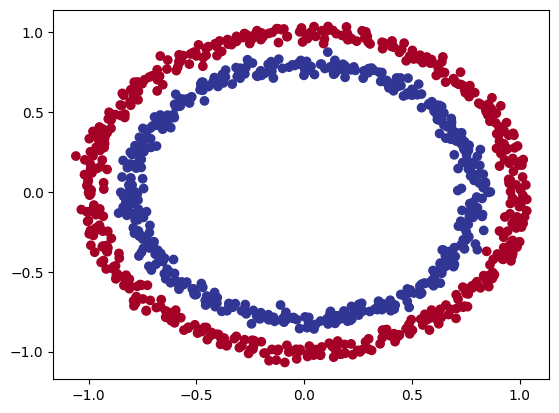

In [7]:
# visualisasi
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

data yang kita kerjakan biasanya dinamai toy data, dataset yang size nya kecil dan cukup untuk melakukan experimen tapi cukup capable untuk melatih fundamental

### 1.1 Check input dan output shape

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shape of one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape of one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensor and create train and test split

In [10]:
import torch
torch.__version__

'2.4.0+cu124'

In [11]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
# check data types
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 0.2 for 20%
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Model

bikin model untuk klasifikasi blue and red dots.

to do so, we want to:
1. Setup Device Agnostic Code, for our code to run in gpu
2. contruct a model, (subclassing `nn.Module`)
3. define loss function and optimizers
4. Create a training and test loop

In [16]:
# import pytorch and nn
import torch
from torch import nn

# buat device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

create a model that:
1. subclassses `nn.Module`
2. create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. define a `forward()`  method that outlines the forward pass
4. instantiate an instance of our model class and send it to target device

In [17]:
from sklearn import datasets

# 1. Construct a model that subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. create 2 nn.Linear layers capable of handling shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # input 2 layers and out 5 layer
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # input 5 and out 1 layer

    # 3. define a forward() method
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

# 4. instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
device

'cuda'

In [19]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [20]:
# replikasi model diatas pakai nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f'length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}')
print(f'length of test samples: {len(X_test)}, shape: {X_test.shape}')
print(f'\nFirst 10 predictions: \n {untrained_preds[:10]}')

length of predictions: 200, shape: torch.Size([200, 1])
length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions: 
 tensor([[ 0.0293],
        [-0.0189],
        [ 0.0765],
        [ 0.0163],
        [-0.0496],
        [-0.0781],
        [-0.1141],
        [-0.1283],
        [ 0.0817],
        [-0.0236]], device='cuda:0')


### 2.1 Setup loss function

untuk regression pakai loss mae or mse (mean absolute error) or (mean square error)

untuk classification pakai binary cross entropy atau categorical cross entropy (cross entropy)

loss function mengukur seberapa salah model tersebut

untuk optimizer, yang paling sering digunakan adalah sgd dan adam

* untuk loss kita pake `torch.nn.BCEWithLogitsLoss()`
* untuk optimizer pake `torch.optim`

In [22]:
# setup loss function
loss_fn = nn.BCEWithLogitsLoss() # loss dengan sigmoid built in

# setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [23]:
# calculate accuracy - out of 100 examples what percentage we would get
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred)) * 100
    return accuracy

## 3. Training a model

untuk training model, kita buat training loop 
1. forward pass
2. calculate loss
3. optimizer zero grad
4. loss backward (backprop)
5. gradient descent (optimizer step)

### 3.1 going from raw logits to -> prediction probabilities -> predictions label

output model_0 ini akan berupa sebuah logits.

kita bisa konversi logits ini ke predictions probability by passing them to somke kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass)

lalu kita bisa konversi hasil dari prediksi model kita menjadi predictions label dengan rounding them or ambil argmax() 

In [24]:
# view the first 5 outputs of the forward pass on the test data.
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0293],
        [-0.0189],
        [ 0.0765],
        [ 0.0163],
        [-0.0496]], device='cuda:0')

In [25]:
# use the sigmoid activation on our models logits and turns them into predictions probabilities
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5073],
        [0.4953],
        [0.5191],
        [0.5041],
        [0.4876]], device='cuda:0')

In [26]:
# find the predicted labels
y_preds = torch.round(y_preds_probs)
y_preds

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

In [27]:
# in full (logits -> pred probs -> pred labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 0., 1., 1., 0.], device='cuda:0')

### 3.2 building training and test loop

more complete version

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs 
epochs = 100

# put data into cuda
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ## training
    model_0.train()
    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    # 1.1 convert into round numbers
    # logits -> pred probs -> pred lables
    y_preds = torch.round(torch.sigmoid(y_logits))
    # 2. calculate loss / accuracy
    # im using y_logits because i'm using BCEWithLogitsLoss
    loss = loss_fn(y_logits, y_train)
    # calculate accuracy
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_preds)
    # 3. zero grad
    optimizer.zero_grad()
    # 4. backprop
    loss.backward()
    # 5. step
    optimizer.step()

    ## perform testing every 10 epoch
    if epoch % 10 == 0:
        model_0.eval()
        with torch.inference_mode():
            # 1.forward pass
            test_logits = model_0(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            # 2.calculate test loss/acc
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        ## print semua info
        if epoch % 10 == 0:
            print(f'Epoch : {epoch} | Train Loss : {loss:.5f}, Train Acc : {accuracy:.2f}% | Test Loss : {test_loss:.5f}, Test Accuracy : {test_acc:.2f}%')

Epoch : 0 | Train Loss : 0.69418, Train Acc : 49.75% | Test Loss : 0.69245, Test Accuracy : 51.50%
Epoch : 10 | Train Loss : 0.69416, Train Acc : 49.62% | Test Loss : 0.69246, Test Accuracy : 51.50%
Epoch : 20 | Train Loss : 0.69413, Train Acc : 49.62% | Test Loss : 0.69247, Test Accuracy : 51.50%
Epoch : 30 | Train Loss : 0.69411, Train Acc : 49.50% | Test Loss : 0.69248, Test Accuracy : 51.00%
Epoch : 40 | Train Loss : 0.69408, Train Acc : 49.62% | Test Loss : 0.69249, Test Accuracy : 50.50%
Epoch : 50 | Train Loss : 0.69406, Train Acc : 49.50% | Test Loss : 0.69250, Test Accuracy : 50.50%
Epoch : 60 | Train Loss : 0.69403, Train Acc : 49.50% | Test Loss : 0.69251, Test Accuracy : 50.50%
Epoch : 70 | Train Loss : 0.69401, Train Acc : 49.38% | Test Loss : 0.69252, Test Accuracy : 50.50%
Epoch : 80 | Train Loss : 0.69399, Train Acc : 49.50% | Test Loss : 0.69253, Test Accuracy : 50.50%
Epoch : 90 | Train Loss : 0.69397, Train Acc : 49.62% | Test Loss : 0.69254, Test Accuracy : 50.50%


## 4. Make Predictions and evaluate the model

from the metrics the model is not learning anything

inspect with making predictions and visualize it

import library mrdbourke `https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py`

In [29]:
import requests
from pathlib import Path

# download helper functions from github
if Path('helper_functions.py').is_file():
    print('helper_functions.py sudah ada, skipping download')
else:
    print('downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

helper_functions.py sudah ada, skipping download


In [30]:
from helper_functions import plot_predictions, plot_decision_boundary

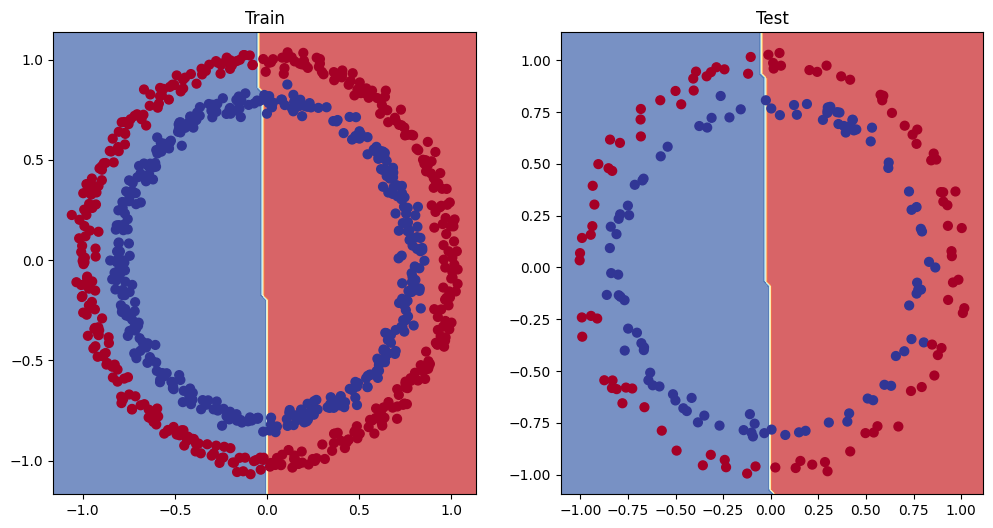

In [31]:
# plot decission boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
### testing purposes